In [19]:
import firebase_admin
import numpy as np
import matplotlib.pyplot as plt
from firebase_admin import credentials, firestore
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import numpy as np

# Firebase Initialization
cred = credentials.Certificate("adminkey.json")
#firebase_admin.initialize_app(cred)
db = firestore.client()

import logging
logging.basicConfig(filename='training_log.txt', level=logging.INFO, format='%(asctime)s - %(message)s')

# Constants
INCLUDE_ONLY = ['Stephen', 'Lillian', 'Ren', 'Yuanheng', 'Ethan']
ACTIVITIES = ['sit', 'walk', 'upstair','downstair']
CHUNK_SIZE = 0.25  # in seconds (can be a decimal)
SAMPLING_RATE = 100  # Hz
START_FROM, END_TO = 200, 300
NUM_CLASSES = 4 

AttributeError: partially initialized module 'pandas' has no attribute 'core' (most likely due to a circular import)

In [18]:
# Data Structures
def fetch_data(collection_name, activities, include_only, time_start=500, time_end=6000):
    """Fetch and preprocess data from Firestore."""
    data, docs = [], []
    for person in db.collection(collection_name).stream():
        person_name = str(person.to_dict().get('name', ''))
        if person_name not in include_only:
            continue

        for activity in activities:
            for recording in db.collection(collection_name).document(person_name).collection(activity).stream():
                record = recording.to_dict()
                if 'acceleration' not in record:
                    continue

                docs.append(record)
                df = pd.DataFrame(record['acceleration'])
                
                if 'time' in df.columns:
                    filtered_df = df[(df['time'] >= time_start) & (df['time'] <= time_end)]
                    data.append(filtered_df)
                else:
                    raise ValueError("The 'acceleration' field must include a 'time' column.")
    return data, docs

# Fetch and preprocess training/testing data
training_data_raw, training_docs = fetch_data("training", ACTIVITIES, INCLUDE_ONLY)
testing_data_raw, testing_docs = fetch_data("testing", ACTIVITIES, INCLUDE_ONLY)

NameError: name 'pd' is not defined

In [46]:
# Function to chunk data into smaller segments for training/testing
def chunk_data(data_raw, docs, chunk_size, activities, sampling_rate):
    """Split data into chunks and assign labels."""
    data, labels = [], []
    activity_distribution = np.zeros(len(activities))
    chunk_samples = int(chunk_size * sampling_rate)  # Convert time to sample count

    for i in range(len(data_raw)):
        num_chunks = len(data_raw[i]) // chunk_samples  # Number of full chunks
        for j in range(num_chunks):
            start = j * chunk_samples
            end = start + chunk_samples
            x = list(data_raw[i]["x"])[start:end]
            y = list(data_raw[i]["y"])[start:end]
            z = list(data_raw[i]["z"])[start:end]
            activity = docs[i]['activity']
            label = activities.index(activity)

            activity_distribution[label] += 1
            data.append([x, y, z])
            labels.append(label)

    return data, labels, activity_distribution

# Chunk the data
training_data, training_labels, training_distribution = chunk_data(training_data_raw, training_docs, CHUNK_SIZE, ACTIVITIES, SAMPLING_RATE)
testing_data, testing_labels, testing_distribution = chunk_data(testing_data_raw, testing_docs, CHUNK_SIZE, ACTIVITIES, SAMPLING_RATE)

In [61]:
print(len(training_data))
print(len(testing_data))
print("Shape of one chunk:", np.array(training_data[0]).shape)
print("Training activity distribution:", training_distribution)
print("Testing activity distribution:", testing_distribution)

704
704
Shape of one chunk: (3, 25)
Training activity distribution: [176. 176. 176. 176.]
Testing activity distribution: [176. 176. 176. 176.]


In [48]:
print("Total training trials:", len(training_data_raw))
print("Total testing trials:", len(testing_data_raw))

Total training trials: 32
Total testing trials: 32


In [51]:
# Save function
def save_model(model, optimizer, filename="model.pth"):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    torch.save(checkpoint, filename)
    print(f"Model saved to {filename}")
# Load function
def load_model(model, optimizer, filename="model.pth"):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f"Model loaded from {filename}")

In [52]:
# Convert the data to NumPy arrays
training_data = np.array(training_data)
testing_data = np.array(testing_data)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(training_data.reshape(-1, training_data.shape[-1])).reshape(training_data.shape)
X_test = scaler.transform(testing_data.reshape(-1, testing_data.shape[-1])).reshape(testing_data.shape)

# Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)  # Shape: (num_samples, 3, chunk_size*100)
y_train = torch.tensor(training_labels, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(testing_labels, dtype=torch.long)

# Create TensorDataset and DataLoader for batching
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, pin_memory=True)

In [53]:
class OptimizedCNNModel(nn.Module):
    def __init__(self, num_classes, input_channels=3, seq_length=int(CHUNK_SIZE * 100)):
        super(OptimizedCNNModel, self).__init__()

        def depthwise_separable_conv(in_channels, out_channels, kernel_size=3, padding=1):
            """Depthwise Separable Convolution for efficiency."""
            return nn.Sequential(
                nn.Conv1d(in_channels, in_channels, kernel_size, groups=in_channels, padding=padding, bias=False),
                nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False),
                nn.GroupNorm(8, out_channels),  # More stable than BatchNorm for small batches
                nn.SiLU()  # Swish activation (better than ReLU)
            )

        self.conv1 = depthwise_separable_conv(input_channels, 32)
        self.conv2 = depthwise_separable_conv(32, 64)
        self.conv3 = depthwise_separable_conv(64, 128)

        # Adaptive pooling to ensure flexible sequence length compatibility
        self.global_pool = nn.AdaptiveAvgPool1d(1)

        # Fully connected layers
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, num_classes)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.4)

        # Weight initialization
        self.apply(self.initialize_weights)

    def initialize_weights(self, m):
        if isinstance(m, nn.Conv1d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool1d(x, 2)

        x = self.conv2(x)
        x = F.max_pool1d(x, 2)

        x = self.conv3(x)
        x = F.max_pool1d(x, 2)

        # Global Average Pooling to reduce to fixed size
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.silu(self.fc1(x))  # Swish activation
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [54]:
# Initialize model, optimizer with weight decay, and loss function
model = OptimizedCNNModel(num_classes=NUM_CLASSES, input_channels=3, seq_length=int(CHUNK_SIZE * 100))
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Weight decay helps reduce overfitting
criterion = nn.CrossEntropyLoss()

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-5)

In [55]:
def calculate_accuracy(loader, model):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():  # disable gradient calc
        for data, targets in loader:
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)  # get predicted class (max value)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    accuracy = 100 * correct / total
    return accuracy

In [56]:
# Training loop with validation
epochs = 50
losses = []
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)

    train_accuracy = calculate_accuracy(train_loader, model)
    test_accuracy = calculate_accuracy(test_loader, model)
    logging.info(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")

    scheduler.step(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")
# Save the model at the end of training
save_model(model, optimizer, "model.pth")

Epoch [1/50], Loss: 1.2797, Train Accuracy: 54.55%, Test Accuracy: 51.56%
Epoch [2/50], Loss: 1.0226, Train Accuracy: 60.94%, Test Accuracy: 58.52%
Epoch [3/50], Loss: 0.9286, Train Accuracy: 64.49%, Test Accuracy: 60.51%
Epoch [4/50], Loss: 0.8249, Train Accuracy: 66.90%, Test Accuracy: 63.21%
Epoch [5/50], Loss: 0.7579, Train Accuracy: 71.16%, Test Accuracy: 65.06%
Epoch [6/50], Loss: 0.7171, Train Accuracy: 71.31%, Test Accuracy: 65.20%
Epoch [7/50], Loss: 0.6857, Train Accuracy: 72.44%, Test Accuracy: 65.34%
Epoch [8/50], Loss: 0.6292, Train Accuracy: 73.01%, Test Accuracy: 66.62%
Epoch [9/50], Loss: 0.6151, Train Accuracy: 75.71%, Test Accuracy: 62.93%
Epoch [10/50], Loss: 0.5977, Train Accuracy: 74.29%, Test Accuracy: 65.34%
Epoch [11/50], Loss: 0.5870, Train Accuracy: 75.00%, Test Accuracy: 65.06%
Epoch [12/50], Loss: 0.5914, Train Accuracy: 76.70%, Test Accuracy: 66.62%
Epoch [13/50], Loss: 0.5716, Train Accuracy: 76.28%, Test Accuracy: 66.05%
Epoch [14/50], Loss: 0.5463, Train

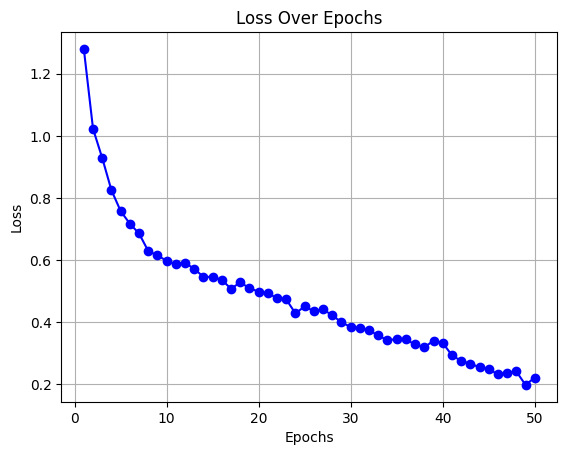

In [57]:
# Plot the loss graph
plt.plot(range(1, epochs + 1), losses, marker='o', linestyle='-', color='b')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

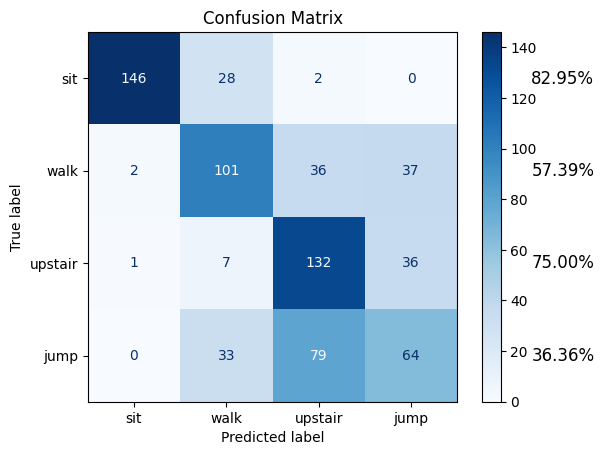

In [58]:
# Import necessary libraries
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Activities for the Confusion matrix
ACTIVITIES = ['sit', 'walk','upstair','jump']

# Model evaluation (confusion matrix)
model.eval()
all_predictions = []
all_labels = []

# Loop through the test loader to collect predictions and true labels
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

# Compute the confusion matrix, explicitly specifying the labels
conf_matrix = confusion_matrix(all_labels, all_predictions, labels=[0, 1, 2,3]) 

# Assuming conf_matrix and ACTIVITIES are already defined
class_accuracies = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)  # Compute per-class accuracy

# Display the confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=ACTIVITIES)
fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax)

# Add per-class accuracy text
for i, activity in enumerate(ACTIVITIES):
    acc_text = f"{class_accuracies[i] * 100:.2f}%"
    ax.text(
        len(ACTIVITIES) + 0.3, i, acc_text, 
        fontsize=12, verticalalignment='center', color='black'
    )

plt.title("Confusion Matrix")
plt.show()

In [59]:
import torch.nn.functional as F

model.eval()  # Set model to evaluation mode
incorrect_samples = []

with torch.no_grad():  # Disable gradient computation
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)  # Get raw logits
        probabilities = F.softmax(outputs, dim=1)  # Convert to probabilities
        predicted_labels = torch.argmax(probabilities, dim=1)  # Get predicted class
        confidence_scores = torch.max(probabilities, dim=1).values  # Get max confidence

        # Find incorrect predictions
        incorrect_indices = (predicted_labels != batch_y)
        for i in range(len(batch_y)):
            if incorrect_indices[i]:
                incorrect_samples.append({
                    "True Label": batch_y[i].item(),
                    "Predicted Label": predicted_labels[i].item(),
                    "Confidence": confidence_scores[i].item(),
                    "Probabilities": probabilities[i].tolist()
                })

# Print results
for sample in incorrect_samples:
    print(f"True Label: {sample['True Label']}, Predicted: {sample['Predicted Label']}, Confidence: {sample['Confidence']:.4f}")
    print(f"Full Probabilities: {sample['Probabilities']}")

True Label: 0, Predicted: 2, Confidence: 0.7111
Full Probabilities: [0.03889035806059837, 0.15380218625068665, 0.7111194729804993, 0.09618794173002243]
True Label: 1, Predicted: 3, Confidence: 0.9872
Full Probabilities: [6.976482836762443e-06, 0.0011046304134652019, 0.011713249608874321, 0.9871751666069031]
True Label: 1, Predicted: 3, Confidence: 0.7084
Full Probabilities: [6.930647941771895e-05, 0.2910885810852051, 0.000422058830736205, 0.7084200382232666]
True Label: 1, Predicted: 3, Confidence: 0.7113
Full Probabilities: [0.00022362626623362303, 0.28840094804763794, 8.192598761525005e-05, 0.7112934589385986]
True Label: 1, Predicted: 2, Confidence: 0.8151
Full Probabilities: [3.670712612802163e-05, 0.1781938225030899, 0.8150577545166016, 0.0067117176949977875]
True Label: 1, Predicted: 3, Confidence: 0.9530
Full Probabilities: [6.378574653354008e-06, 0.04701630398631096, 2.6997267923434265e-05, 0.9529502987861633]
True Label: 1, Predicted: 3, Confidence: 0.5671
Full Probabilities: 